# Final Assingment  
Shlomo Amor - 000803254 
Dean Meyer - 000802794

## Research Proposal:

#### Introduction:

The hypothesis this research project will test is whether there is quantitative evidence to prove market movements prior to the Financial crisis of 2007–2008 was statistically similar to the pre-corona crisis.
With the coronavirus still spreading, the shock to the global economies is becoming ever more apparent. The extent of the fall has shocked most including experienced traders and investors. Is a systemic financial crisis likely, perhaps along the lines of the crisis 12 years ago in 2008?                                                                        
There are certainly similarities: widespread bankruptcies, liquidity shortages, large losses and some financial institutions may fail. In the proposed research project, we will compare and contrast between the coronavirus crisis with the 2008 financial crisis and in the process, gain some intelligence on the likelihood of a systemic crisis as a consequence of coronavirus.
Our research will be solely based on data gathered from the US and the UK. We will use different means to conclude our research such statistically analysing different financial benchmarks including the VIX indicator, gold price, ETF’s representing different industries, , price of crude oil and price of gas.

####  Models and Methods:

We hope to gather enough data prior to both crisis. We will collect data from various verticals including the economy, healthcare system and financial system. 
We will begin by statistically analysing the Financial crisis of 2007–2008 and COVID and technically understanding them while obtaining the most credible data. We will use reference to Bayesian Statistics where we will relate to further understanding our data using Markov Chain Monte Carlo techniques that we learnt in lecture. Overall, we aim to create a linear regression model on the financial crisis data and test this model on the COVID crisis data. More specifically, we will use the previous days features to predict the next day's S&P500 stock price. We will use two differing methods to find the optimal regression model. Firstly, we will use the Gradient Descent approach and secondly, we use the Bayseian Markov chain Monte Carlo (MCMC) method.

#### Expected results: --------------------------------------- GET BACK TO THIS WHEN WE HAVE CONCLUSION

Firstly, we expect to find similar relationships between volatility and gold price movements between COVID and the 2008 financial crisis. Furthermore, we expect to find strong correlations between the movement of the S&P 500 during COVID and the 2008 financial crisis.

## Implementation:

In [92]:
import numpy as np # used for scientific computing
import pandas as pd # used for data analysis and manipulation
import matplotlib.pyplot as plt # used for visualization and plotting
import matplotlib.dates as mdates
import seaborn as sns
import wget
import os
from sklearn import preprocessing
import pymc3 as pm
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# Downloading data
url1 = 'https://raw.githubusercontent.com/deanmeyer10/Financial_Covid_Crisis_Analysis/master/Financial.csv'
url2 = 'https://raw.githubusercontent.com/deanmeyer10/Financial_Covid_Crisis_Analysis/master/Covid.csv'
wget.download(url1, 'Financial_dataset.csv')
wget.download(url2, 'Covid_dataset.csv')

100% [..............................................................................] 10623 / 10623

'Covid_dataset.csv'

### Auxiliary Functions:

In [4]:
def plot_diagrams(df, date_range):
    fig, axes = plt.subplots(2, 3,figsize=(20, 14), sharey=False)
    ax = axes[0][0]
    ax.plot(df['Date'], df['S&P500 $'], 'ro', ms=1, mec='k',c='red') 
    ax.axvspan(*mdates.datestr2num(date_range), color='red', alpha=0.1)
    ax.set_ylabel('S&P500 $')
    ax.set_xlabel('Dates')
    ax.set_title('S&P500')

    ax = axes[0][1]
    ax.plot(df['Date'], df['Vix $'], 'ro', ms=1, mec='k',color='blue') 
    ax.axvspan(*mdates.datestr2num(date_range), color='red', alpha=0.1)
    ax.set_ylabel('Vix $')
    ax.set_xlabel('Dates')
    ax.set_title('Vix')

    ax = axes[0][2]
    ax.plot(df['Date'], df['Gold Price $'], 'ro', ms=1, mec='k',color='green') 
    ax.axvspan(*mdates.datestr2num(date_range), color='red', alpha=0.1)
    ax.set_ylabel('Gold Price $')
    ax.set_xlabel('Dates')
    ax.set_title('Gold Price')

    ax = axes[1][0]
    ax.plot(df['Date'], df['Crude Oil Price $'], 'ro', ms=1, mec='k',color='green') 
    ax.axvspan(*mdates.datestr2num(date_range), color='red', alpha=0.1)
    ax.set_ylabel('Crude Oil Price $')
    ax.set_xlabel('Dates')
    ax.set_title('Crude Oil Price')
    
    ax = axes[1][1]
    ax.plot(df['Date'], df['Gas $'], 'ro', ms=1, mec='k',color='green') 
    ax.axvspan(*mdates.datestr2num(date_range), color='red', alpha=0.1)
    ax.set_ylabel('Gas $')
    ax.set_xlabel('Dates')
    ax.set_title('Gas Price')
    fig.delaxes(axes[1,2])
    plt.show()  

In [5]:
def plot_correlation_pairs(corr,df_filtered_by_date):    
    #select correlated features
    corr_np = corr.values
    np.fill_diagonal(corr_np, 0)
    #indices of the absolute max correlation for each feature
    max_corr_indices = np.argmax(np.abs(corr_np), axis=1)
    corr_indices = corr.index
    max_corr_pairs = np.unique([{corr_indices[i], corr_indices[max_corr_indices[i]]} for i in range(5)])

    #plot correlation features
    i = 0
    fig, axes = plt.subplots(1, len(max_corr_pairs),figsize=(20, 5), sharey=False)
    for pair in max_corr_pairs:
        t = list(pair)

        ax = axes[i]
        color = 'tab:green'
        ax.set_xlabel('Date',fontsize=15)
        a, = ax.plot(df_filtered_by_date['Date'], df_filtered_by_date[t[0]], '-', ms=1, mec='k',color=color, label =t[0])
        ax.tick_params(axis='y', labelcolor=color)

        # instantiate a second axes that shares the same x-axis
        ax2 = ax.twinx()  
        color = 'tab:red'
        b, = ax2.plot(df_filtered_by_date['Date'], df_filtered_by_date[t[1]], '-', ms=1, mec='k',color=color, label =t[1] )
        ax2.tick_params(axis='y', labelcolor=color)

        p = [a, b]
        ax.legend(p, [p_.get_label() for p_ in p], fontsize= 'large')
        ax.set_title('Correlation plot: '+str(t[0])+' vs. '+str(t[1]),fontsize=12)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped

        i+=1

    plt.show()

## Part 1: Data Visualization and Data Analysis

### Data Visualization:

In [6]:
# Read comma separated data
df_fin_crisis = pd.read_csv('Financial_dataset.csv') 
df_covid_crisis = pd.read_csv('Covid_dataset.csv')

### Exploration of the financial crisis data:
#### Data information:
* Starting date: <b>  3.1.06</b> 
* Ending date:   <b>  31.12.10</b> 
* Features: 
    * S&P500 
    * Vix 
    * Gold Price 
    * Crude Oil Price 	
    * Gas Price


In [7]:
df_fin_crisis = df_fin_crisis.dropna(axis=0)
df_fin_crisis['Date'] = pd.to_datetime(df_fin_crisis['Date'], dayfirst=True)
df_fin_crisis.head(10)

,Date,S&P500 $,Vix $,Gold Price $,Crude Oil Price $,Gas $
0,2006-01-03,1268.800049,11.14,530.700012,63.139999,10.626
1,2006-01-04,1273.459961,11.37,533.900024,63.419998,10.197
2,2006-01-05,1273.479980,11.31,526.299988,62.790001,9.499
3,2006-01-06,1285.449951,11.00,539.700012,64.209999,9.632
5,2006-01-09,1290.150024,11.13,549.099976,63.500000,9.390
6,2006-01-10,1289.689941,10.86,544.299988,63.369999,9.336
7,2006-01-11,1294.180054,10.94,548.799988,63.939999,9.238
8,2006-01-12,1286.060059,11.20,548.299988,63.939999,8.943
9,2006-01-13,1287.609985,11.23,556.099976,63.919998,8.791
12,2006-01-17,1282.930054,11.91,553.400024,66.309998,9.168


In [8]:
df_fin_crisis.describe()

,S&P500 $,Vix $,Gold Price $,Crude Oil Price $,Gas $
count,1157.000000,1157.000000,1157.000000,1157.000000,1157.000000
mean,1232.418012,23.127926,858.242178,76.460899,6.479908
std,204.434679,12.081865,226.642224,20.749729,2.131946
min,676.530029,9.890000,526.299988,33.869999,2.508000
25%,1094.900024,14.290000,656.700012,63.130001,4.639000
50%,1272.880005,21.139999,848.900024,72.519997,6.533000
75%,1397.680054,25.920000,974.200012,83.690002,7.658000
max,1565.150024,80.860001,1421.099976,145.179993,13.505000


We plot each feature to better understand what are data looks like and to understand if there are any linear relationships between features

### Data Analysis: Financial Crisis 2008:


We begin by identifying when the Financial crisis began. After extensive research we have decided that the crisis took real effect during from the 1st of January 2008 and ended 1st July 2009. See below the red marked area detailing the period from the extreme beginning to the end of the financial crisis.

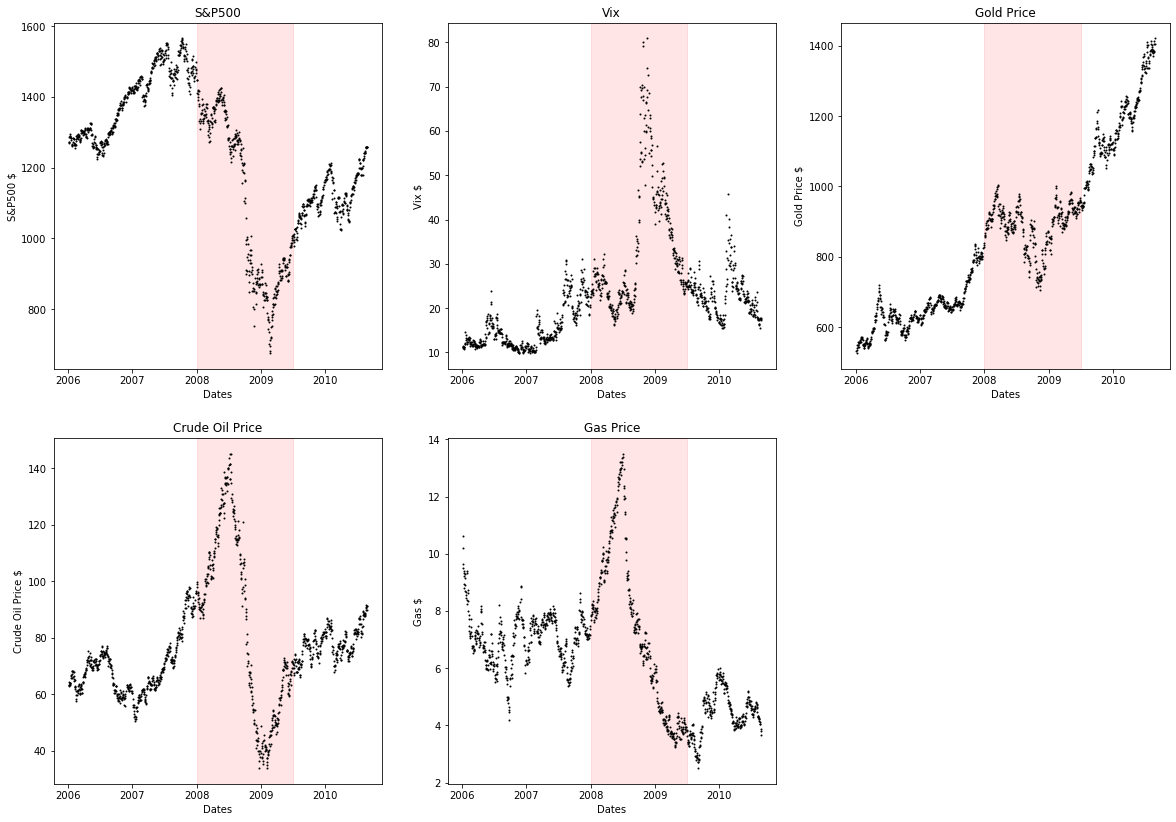

In [15]:
plot_diagrams(df_fin_crisis,['01/01/2008', '07/01/2009'])

#### Analysis of Extreme Period (Red Zone)
To better understand the extremities of the red zone, we will isolate the red zone from the data for this analysis. To relate the cause and impact of the 2008 Financial Crisis in relation to the COVID 19 pandemic by analyzing the factors we have chosen, it is crucial to first understand how the metrics chosen were affected in different ways during the "actual" time of crisis.


Firstly, we begin my analyzing the magnitude of the crash per feature by calculating the percentage changes from the maximum value to the respective minimum value in order to better understand the true downturn of the feature during the period of crisis. 

In [10]:
# Selecting all the data in the identified crisis range
df_filtered_by_date_f = df_fin_crisis[df_fin_crisis["Date"] >= "01/01/2008"]
df_filtered_by_date_f = df_filtered_by_date_f[df_filtered_by_date_f["Date"]<= "01/07/2009"]
# Collecting max and min for each feature
max_variables = df_filtered_by_date_f.max()
min_variables = df_filtered_by_date_f.min()
magnitude = (max_variables[1:]-min_variables[1:])/min_variables[1:]
pd.concat([max_variables, min_variables,magnitude], axis=1, keys=["Max","Min","Magnitude"], sort=False)

,Max,Min,Magnitude
Date,2009-01-07 00:00:00,2008-01-02 00:00:00,NaN
S&P500 $,1447.16,752.44,0.92329
Vix $,80.86,16.3,3.96074
Gold Price $,1003.2,704.9,0.423181
Crude Oil Price $,145.18,33.87,3.28639
Gas $,13.505,5.294,1.551


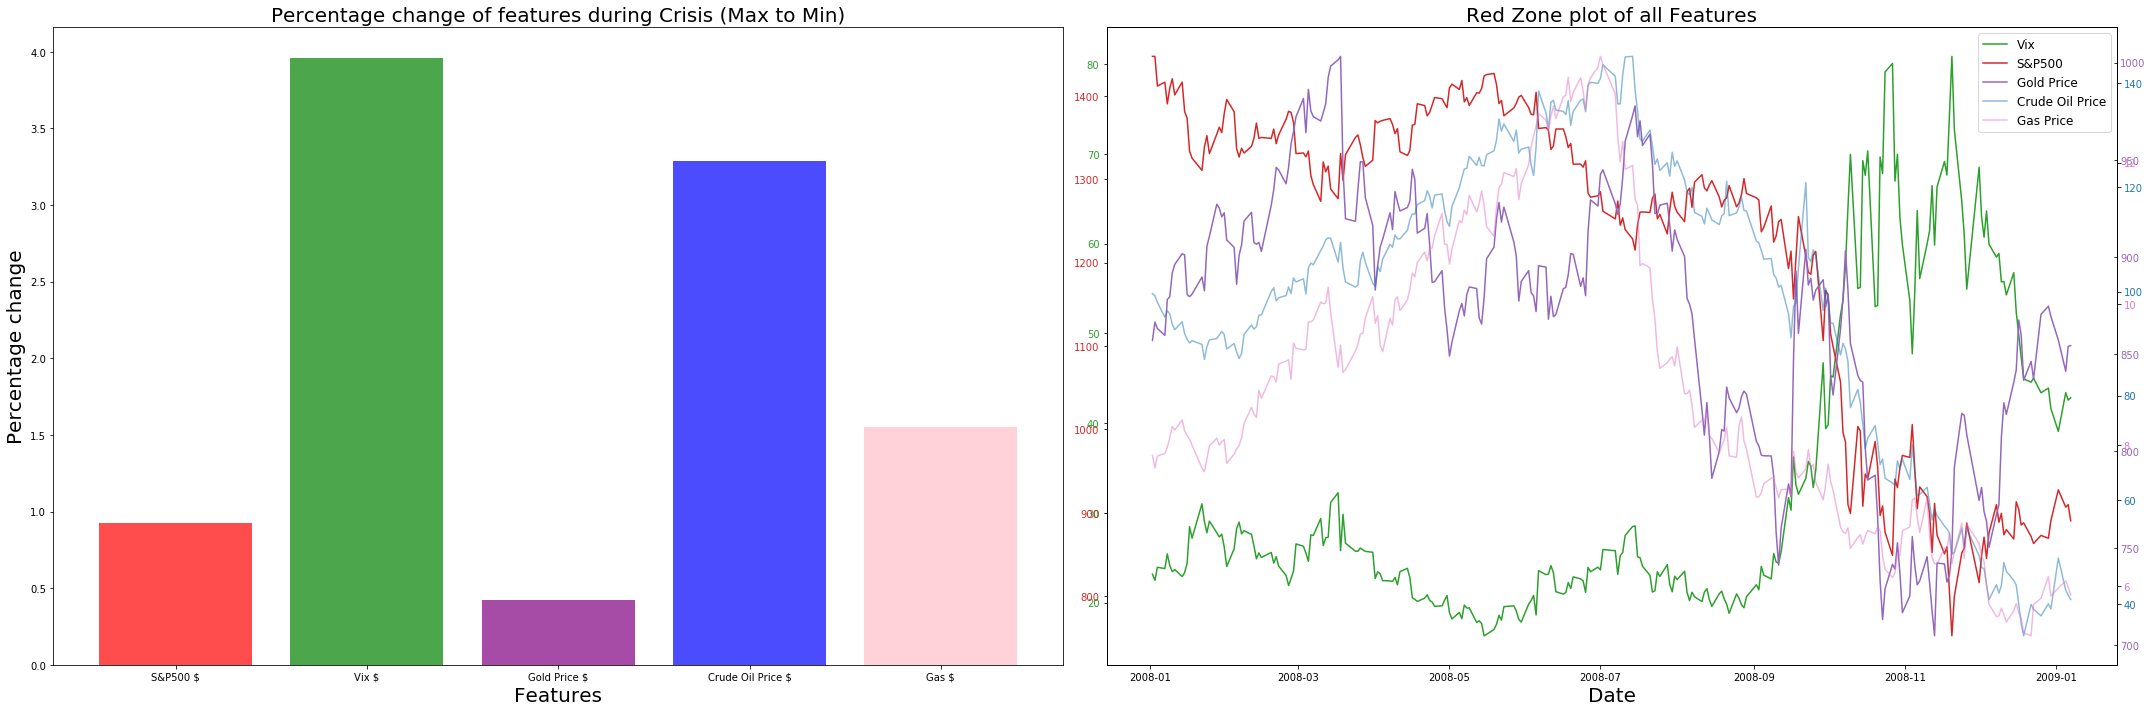

In [16]:
fig, axes = plt.subplots(1, 2,figsize=(30, 10), sharey=False)

ax = axes[0]
x = magnitude.index.values
y = magnitude.values
ax.bar(x,y, color = ["red", "green", "purple", "blue", "pink"], alpha=0.7)
ax.set_xlabel('Features',fontsize=20)
ax.set_ylabel('Percentage change',fontsize=20)
ax.set_title('Percentage change of features during Crisis (Max to Min)',fontsize=20)

ax = axes[1]
color = 'tab:green'
ax.set_xlabel('Date',fontsize=20)
a, = ax.plot(df_filtered_by_date_f['Date'], df_filtered_by_date_f['Vix $'], '-', ms=1, mec='k',color=color, label ="Vix")
ax.tick_params(axis='y', labelcolor=color)
# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()  
color = 'tab:red'
b, = ax2.plot(df_filtered_by_date_f['Date'], df_filtered_by_date_f['S&P500 $'], '-', ms=1, mec='k',color=color, label ="S&P500" )
ax2.tick_params(axis='y', labelcolor=color)
 # instantiate a third axes that shares the same x-axis
ax3 = ax.twinx() 
color = 'tab:purple'
c, = ax3.plot(df_filtered_by_date_f['Date'], df_filtered_by_date_f['Gold Price $'], '-', ms=1, mec='k',color=color, label ="Gold Price" )
ax3.tick_params(axis='y', labelcolor=color, direction="in")
# instantiate a forth axes that shares the same x-axis
ax4 = ax2.twinx() 
color = 'tab:blue'
d, = ax4.plot(df_filtered_by_date_f['Date'], df_filtered_by_date_f['Crude Oil Price $'], '-', ms=1, mec='k',color=color, label ="Crude Oil Price", alpha=0.5)
ax4.tick_params(axis='y', labelcolor=color)

# instantiate a forth axes that shares the same x-axis
ax5 = ax2.twinx() 
color = 'tab:pink'
e, = ax5.plot(df_filtered_by_date_f['Date'], df_filtered_by_date_f['Gas $'], '-', ms=1, mec='k',color=color, label ="Gas Price", alpha=0.5)
ax5.tick_params(axis='y', labelcolor=color)

# Setting the labels for all axes
p = [a, b,c,d,e]
ax.legend(p, [p_.get_label() for p_ in p], fontsize= 'large')
ax.set_title('Red Zone plot of all Features',fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Change in Magnitude of Features during the Crisis

<b>Key Takeaways from the plots:</b>

- <b> Gold was least affected as well as most stable feature</b>

    As can be seen from the above diagrams, it is clear the Gold prices were least affected as it experienced the least percentage change in price. This shows the economic value that Gold holds as a historical value as it has been recognized as a form of money for thousands of years. Furthermore, the supply of Gold is limited and therefore, it cannot be printed by the government to increase or decrease its value. This means that gold is always going to be valuable, that is never going to change. For these reasons, gold tends to be a "Market Haven" during high stress and volitally and thus, why its value was the least affected during the financial crisis.

- <b> Vix (volatility Index) showed the largest change in value</b>


    Conversely to this, the Vix indicator experienced the greatest change as the Vix indicator is a measure of volatility of the S&P500 index. Thus, during volatile times such as the Financial crisis we expect the idicator to increase. This can be clearly seen on the left diagram.

-  <b> Crude Oil had an extremely large drop in price</b>

    Interestingly, the crude oil plummeted from close to 140 dollars a barrel to 40 dollars hence, the large second largest percentage change feature. The price of oil plays a crucial role in the determination of the price of gold and gold-backed ETFs. Like gold, the price of crude oil is determined in the US dollar value. When the US dollar rises, dollar-denominated assets usually drop in price, as investors of other currencies find dollar-denominated assets more expensive. Because gold and crude oil are dollar-denominated assets, they are strongly linked. 




#### Duration of Time Taken from Max to Min values

To understand the relationship between features during times of Crisis, it is important to understand how quickly their prices were hit by the crash. Thus, below, we find the times taken for each feature to go from their highest point to lowest point or visa versa during the financial crisis period.

In [12]:
#Get days from top to bottom time duration
def get_days(feature):
    date_max_SP = df_filtered_by_date_f[df_filtered_by_date_f[feature] == max_variables[feature]]['Date'][:1]
    date_min_SP = df_filtered_by_date_f[df_filtered_by_date_f[feature] == min_variables[feature]]['Date']
    return (date_min_SP.values[0] - date_max_SP.values[0]).astype('timedelta64[D]') / np.timedelta64(1, 'D')


days = np.abs([get_days("S&P500 $"), get_days("Vix $"), get_days("Gold Price $"),get_days("Crude Oil Price $"),get_days("Gas $")])
days_dict = {'S&P500 $':days[0], 'Vix $':days[1], 'Gold Price $':days[2],'Crude Oil Price $':days[3],'Gas $':days[4]}

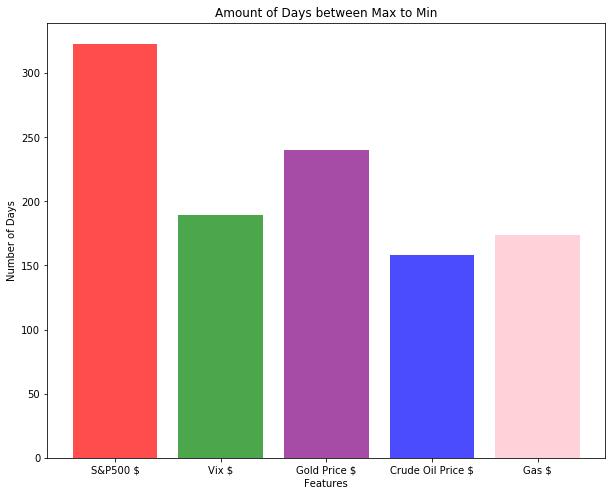

In [19]:
#plot days
x = list(days_dict.keys())
y = list(days_dict.values())
plt.bar(x,y, color = ["red", "green", "purple", "blue", "pink"], alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Number of Days')
plt.title('Amount of Days between Max to Min')
plt.show()

<b>Key Takeaways from the plots:</b>

-  <b> S&P500 was by far the slowest to reach its lows</b>

    The S&P500 is a stock market index that measures the stock performance of 500 large companies listed on stock exchanges in the United States. From our research, we hypothesize that the slow downturn of the S&P500 is mainly due to the fact that it is an ETF whereby its price is influenced by over 500 companies from different sectors. As different industries and sectors were affected at different rates, the S&P500 was pulled in all directions, slowing its downturn.

-  <b> Crude Oil and Gas prices plummeted</b>

    The recession caused demand for energy to shrink in late 2008, with oil prices collapsing from the July 2008 high of USD147 to a December 2008 low of USD32. However, it has been disputed that the laws of supply and demand of oil could have been responsible for an almost 80% drop in the oil price within a 6 month period.


#### Correlation Analysis:

- The<b> Pearson correlation</b> represents linear relationships between variables holding the values between -1 to 1, where 0 represents no corrrelation, 1 represents fully linear positive correlation and finally, -1 represents a linear negative correlation.


- The <b>Kendall rank correlation</b> coefficient, commonly referred to as Kendall's τ coefficient, is a statistic used to measure the ordinal association between two measured quantities. A τ test is a non-parametric hypothesis test for statistical dependence based on the τ coefficient

In [20]:
## Getting the correlation between the data
corr_p = df_filtered_by_date_f.corr()
corr_p_copy = corr_p.copy()
corr_p_copy.insert(5, "|| "," || ")

corr_s = df_filtered_by_date_f.corr(method='spearman')
corr_s_copy = corr_s.copy()
corr_s_copy.insert(5, "|| "," || ")

corr_k = df_filtered_by_date_f.corr(method='kendall')
pd.concat([corr_p_copy, corr_s_copy, corr_k], axis=1, keys=["Pearson","Spearman","Kendall"], sort=False)

Pearson                                           \
                   S&P500 $     Vix $ Gold Price $ Crude Oil Price $   
S&P500 $           1.000000 -0.930100     0.654501          0.816484   
Vix $             -0.930100  1.000000    -0.646839         -0.803443   
Gold Price $       0.654501 -0.646839     1.000000          0.578055   
Crude Oil Price $  0.816484 -0.803443     0.578055          1.000000   
Gas $              0.713502 -0.689072     0.595381          0.873256   

                                   Spearman                         \
                      Gas $   ||   S&P500 $     Vix $ Gold Price $   
S&P500 $           0.713502   ||   1.000000 -0.783781     0.503293   
Vix $             -0.689072   ||  -0.783781  1.000000    -0.335540   
Gold Price $       0.595381   ||   0.503293 -0.335540     1.000000   
Crude Oil Price $  0.873256   ||   0.537159 -0.776619     0.497199   
Gas $              1.000000   ||   0.707006 -0.737151     0.659790   

                                                      Kendall            \
                  Crude Oil Price $     Gas $   ||   S&P500 $     Vix $   
S&P500 $                   0.537159  0.707006   ||   1.000000 -0.609896   
Vix $                     -0.776619 -0.737151   ||  -0.609896  1.000000   
Gold Price $               0.497199  0.659790   ||   0.306671 -0.215478   
Crude Oil Price $          1.000000  0.900267   ||   0.368000 -0.557372   
Gas $                      0.900267  1.000000   ||   0.517773 -0.530074   

                                                            
                  Gold Price $ Crude Oil Price $     Gas $  
S&P500 $              0.306671          0.368000  0.517773  
Vix $                -0.215478         -0.557372 -0.530074  
Gold Price $          1.000000          0.338961  0.447847  
Crude Oil Price $     0.338961          1.000000  0.746541  
Gas $                 0.447847          0.746541  1.000000

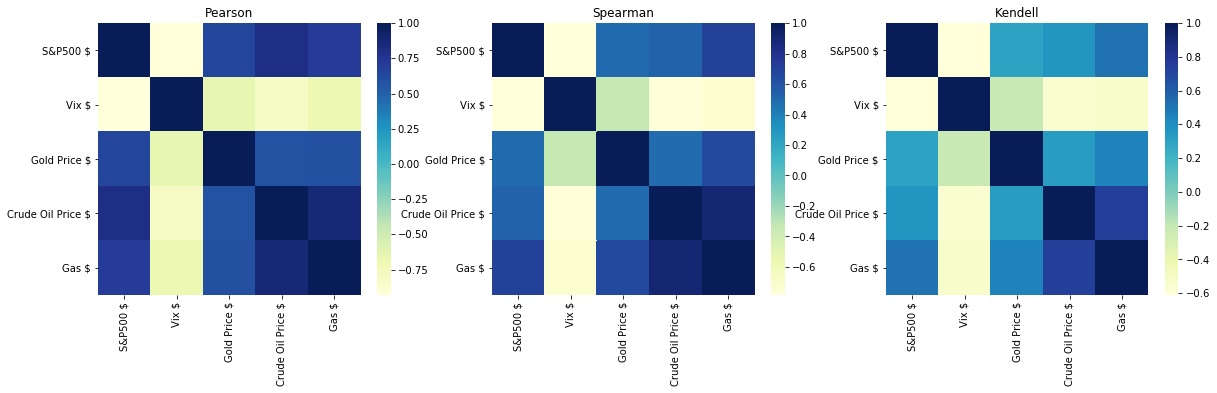

In [21]:
# Plotting the correlations in heatmap form
fig, ax = plt.subplots(1,3,figsize=(20, 5), sharey=False)
sns.heatmap(corr_p, cmap="YlGnBu",ax=ax[0])
ax[0].set_title("Pearson")
sns.heatmap(corr_s, cmap="YlGnBu",ax=ax[1])
ax[1].set_title("Spearman")
sns.heatmap(corr_k, cmap="YlGnBu",ax=ax[2])
ax[2].set_title("Kendell")
plt.show()

##### We find the Maximum pairwise correlations for each feature and plot the relevant features

#### Pearson: Pairwise correlation 

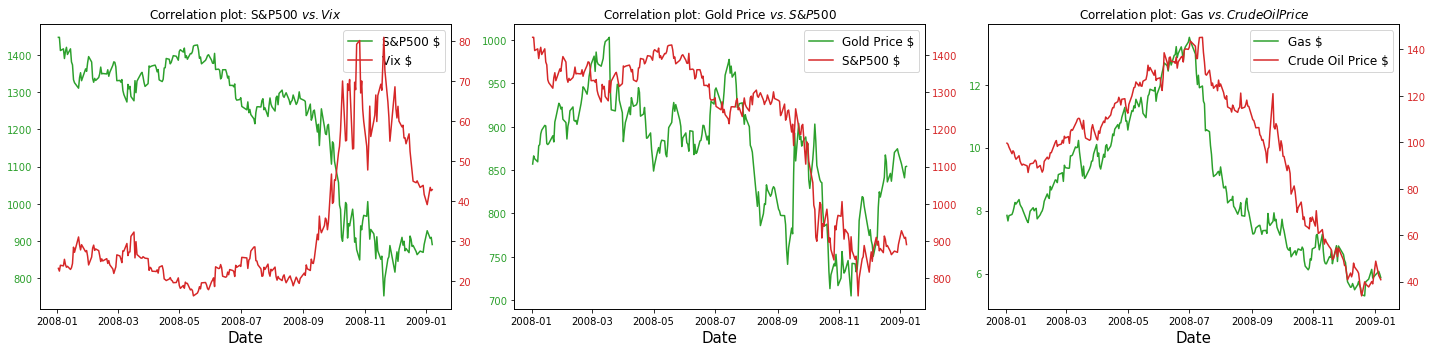

In [22]:
plot_correlation_pairs(corr_p,df_filtered_by_date_f)  

#### Spearman: Pairwise correlation 

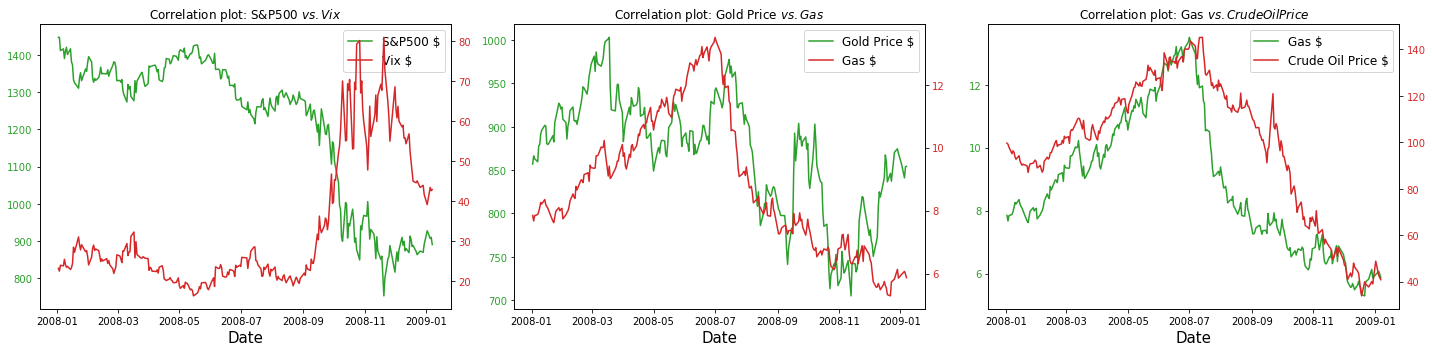

In [23]:
plot_correlation_pairs(corr_s,df_filtered_by_date_f) 

#### Kendall: Pairwise correlation 

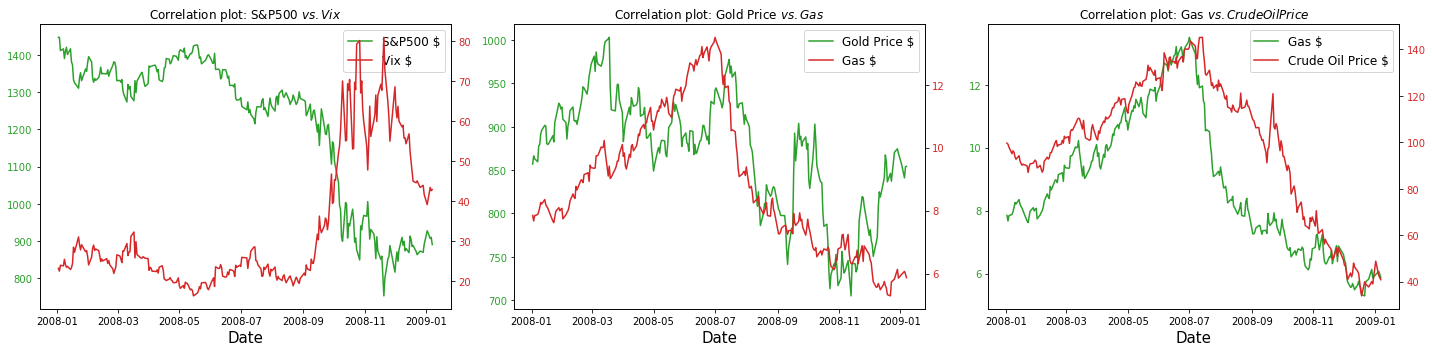

In [24]:
plot_correlation_pairs(corr_k,df_filtered_by_date_f) 

<b>Key Takeaways from the plots:</b>

- <b> S&P500 and Vix are strongly negativly correlated:</b> 

    The Vix Index is a popular measure of the stock market's expectation of volatility based on S&P 500 index options. When the market goes down, investors would want to purchase insurance, which drives up the prices of put options and increases the VIX. The VIX decreases when there's less demand for put options as the market rises. That's why it tends to move inversely to equities.

- <b> Gas and Crude oil are strongly positively correlated:</b> 

    As natural gas is often a byproduct of drilling for crude oil, it seems logical there would be a positive correlation between the commodities.

### Exploration of the Covid-19 crisis data:
#### Data information:
* Starting date: <b>  2.12.19</b> 
* Ending date:  <b>   6.8.20</b> 
* Features: 
    * S&P500 
    * Vix 
    * Gold Price 
    * Crude Oil Price 	
    * Gas Price

In [25]:
df_covid_crisis = df_covid_crisis.dropna(axis=0)
df_covid_crisis['Date'] = pd.to_datetime(df_covid_crisis['Date'], dayfirst=True)
df_covid_crisis.head(10)

,Date,S&P500 $,Vix $,Gold Price $,Crude Oil Price $,Gas $
0,2019-12-02,3113.870117,14.91,1462.300049,55.959999,2.329
1,2019-12-03,3093.199951,15.96,1478.199951,56.099998,2.441
2,2019-12-04,3112.760010,14.80,1474.000000,58.430000,2.399
3,2019-12-05,3117.429932,14.52,1476.900024,58.430000,2.427
4,2019-12-06,3145.909912,13.62,1459.099976,59.200001,2.334
6,2019-12-09,3135.959961,15.86,1459.300049,59.020000,2.232
7,2019-12-10,3132.520020,15.68,1462.599976,59.240002,2.264
8,2019-12-11,3141.629883,14.99,1469.400024,58.759998,2.243
9,2019-12-12,3168.570068,13.94,1466.699951,59.180000,2.328
10,2019-12-13,3168.800049,12.63,1475.599976,60.070000,2.296


In [26]:
df_covid_crisis.describe()

,S&P500 $,Vix $,Gold Price $,Crude Oil Price $,Gas $
count,170.000000,170.000000,170.000000,170.000000,170.000000
mean,3047.911467,29.686824,1662.113530,40.111000,1.867547
std,257.478702,15.382139,125.420914,15.164225,0.212756
min,2237.399902,12.100000,1459.099976,-37.630001,1.482000
25%,2879.157470,15.475000,1565.224976,28.882501,1.729500
50%,3120.365112,27.895001,1671.600036,40.414999,1.821000
75%,3239.784912,35.767500,1734.274994,52.117499,1.935500
max,3386.149902,82.690002,2031.099976,63.270000,2.441000


### Data Analysis: Covid-19 Crisis:


We begin by identifying when the Covid-19 crisis began. After some extensive research we have decided that the crisis began on the 31st of January 2020 

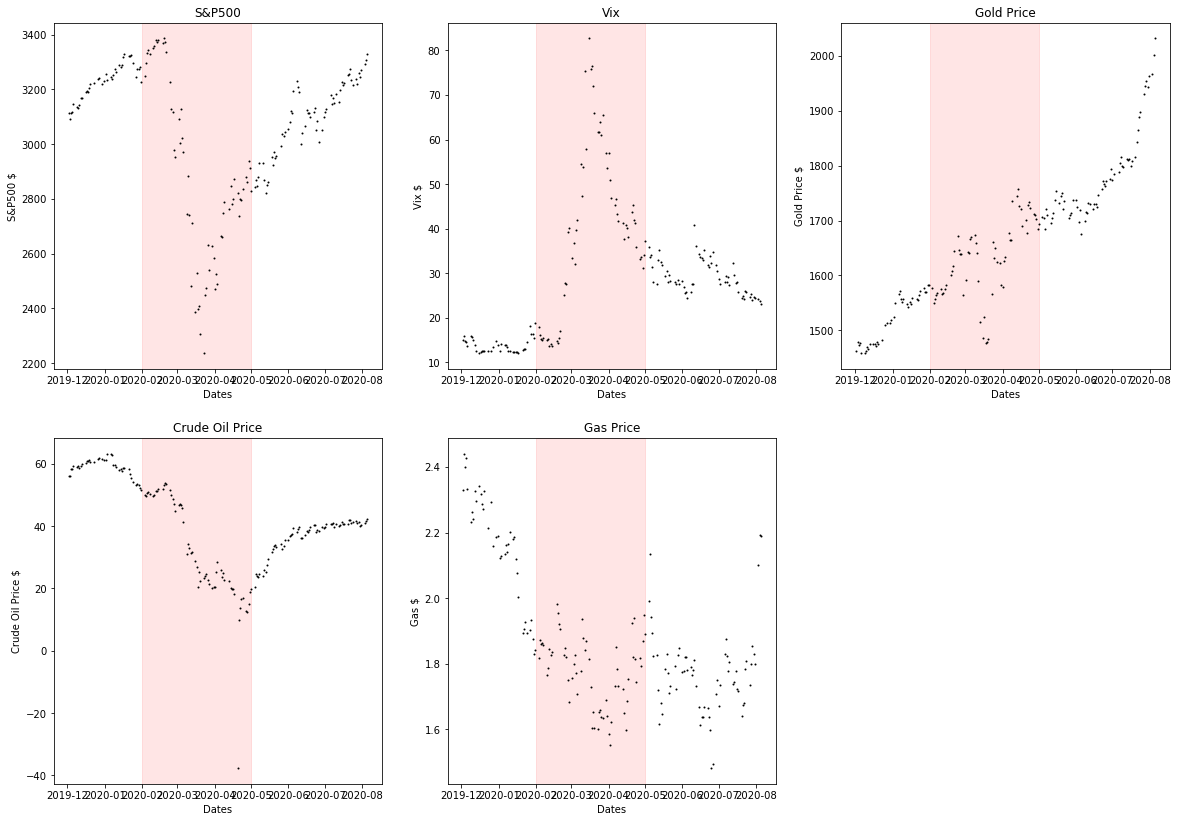

In [27]:
plot_diagrams(df_covid_crisis,['02/01/2020', '05/01/2020'])

#### Analysis of extreme changes during the Crisis (Red Zone)
To better understand the extremities of the red zone, we will isolate the red zone from the data for this analysis.
Firstly, we begin my analyzing the magnitude of the crash per feature by calculating the percentage changes from the maximum value to the respective minimum value in order to better understand the true downturn of the feature during the period of crisis. 
Furthermore, we collect the max and min for each feature in order to calcualte the magnitude of the crash for different features.



In [28]:
# Selecting all the data in the identified crisis range
df_filtered_by_date_c = df_covid_crisis[df_covid_crisis["Date"] >= "02/01/2020"]
df_filtered_by_date_c = df_filtered_by_date_c[df_filtered_by_date_c["Date"]<= "05/01/2020"]
# Collecting max and min for each feature
max_variables = df_filtered_by_date_c.max()
min_variables = df_filtered_by_date_c.min()
magnitude = (max_variables[1:]-min_variables[1:])/min_variables[1:]
pd.concat([max_variables, min_variables,magnitude], axis=1, keys=["Max","Min","Magnitude"], sort=False)

,Max,Min,Magnitude
Date,2020-05-01 00:00:00,2020-02-03 00:00:00,NaN
S&P500 $,3386.15,2237.4,0.513431
Vix $,82.69,13.68,5.04459
Gold Price $,1756.7,1477.3,0.189129
Crude Oil Price $,53.78,-37.63,-2.42918
Gas $,1.981,1.552,0.276418


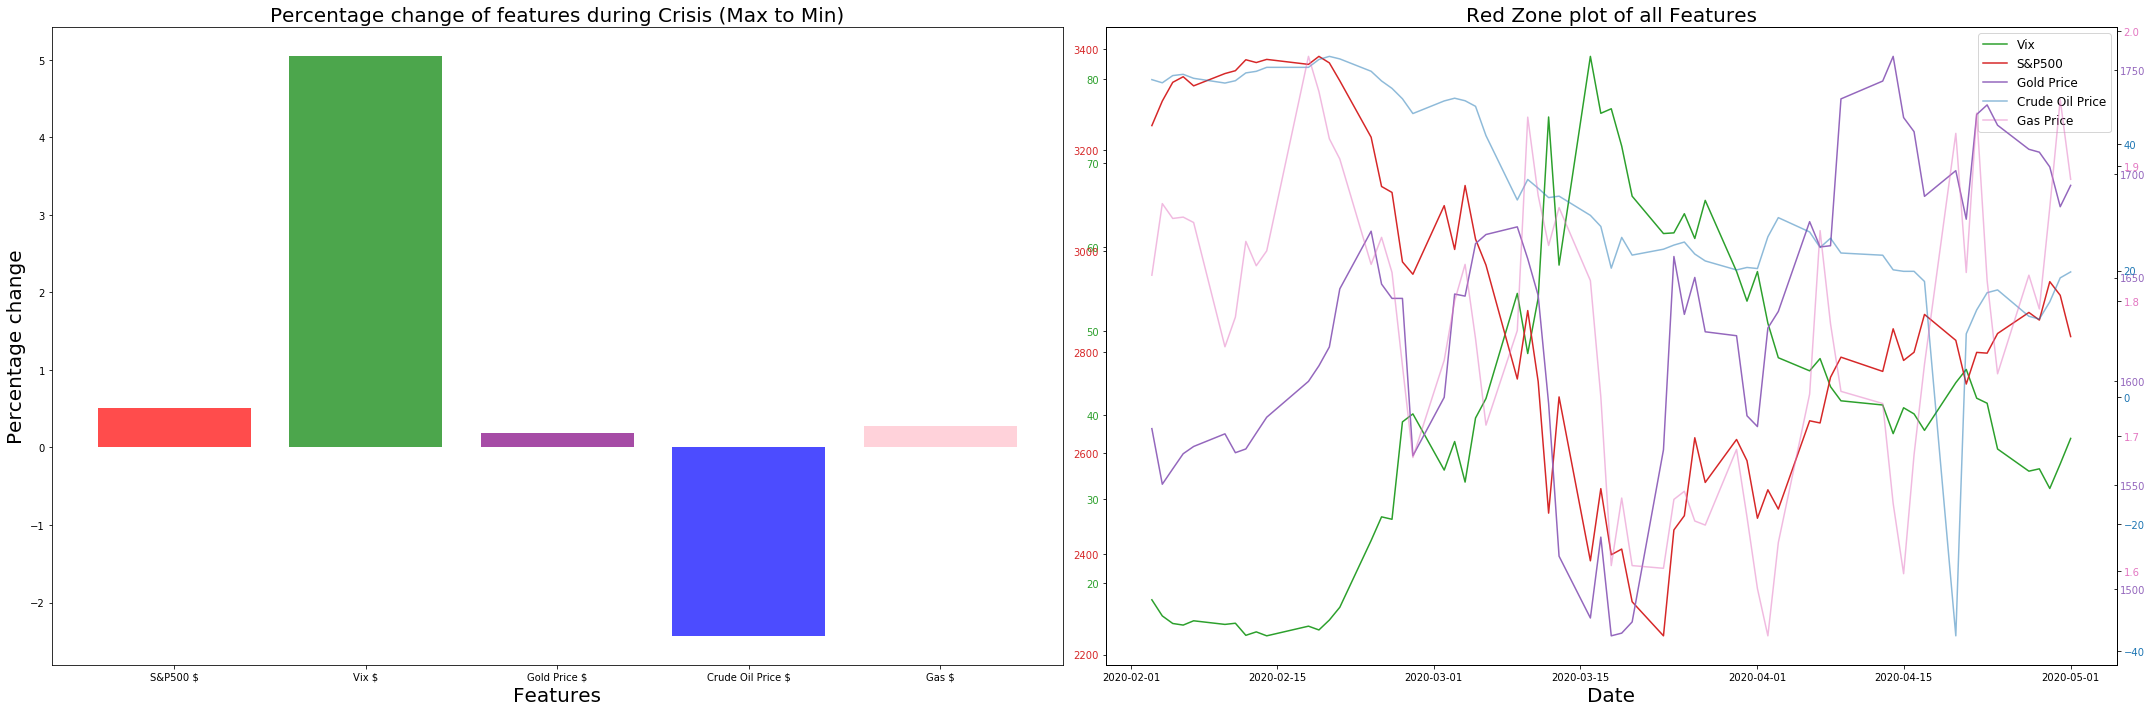

In [29]:
fig, axes = plt.subplots(1, 2,figsize=(30, 10), sharey=False)

ax = axes[0]
x = magnitude.index.values
y = magnitude.values
ax.bar(x,y, color = ["red", "green", "purple", "blue", "pink"], alpha=0.7)
ax.set_xlabel('Features',fontsize=20)
ax.set_ylabel('Percentage change',fontsize=20)
ax.set_title('Percentage change of features during Crisis (Max to Min)',fontsize=20)

ax = axes[1]
color = 'tab:green'
ax.set_xlabel('Date',fontsize=20)
a, = ax.plot(df_filtered_by_date_c['Date'], df_filtered_by_date_c['Vix $'], '-', ms=1, mec='k',color=color, label ="Vix")
ax.tick_params(axis='y', labelcolor=color)
# instantiate a second axes that shares the same x-axis
ax2 = ax.twinx()  
color = 'tab:red'
b, = ax2.plot(df_filtered_by_date_c['Date'], df_filtered_by_date_c['S&P500 $'], '-', ms=1, mec='k',color=color, label ="S&P500" )
ax2.tick_params(axis='y', labelcolor=color)
 # instantiate a third axes that shares the same x-axis
ax3 = ax.twinx() 
color = 'tab:purple'
c, = ax3.plot(df_filtered_by_date_c['Date'], df_filtered_by_date_c['Gold Price $'], '-', ms=1, mec='k',color=color, label ="Gold Price" )
ax3.tick_params(axis='y', labelcolor=color, direction="in")
# instantiate a forth axes that shares the same x-axis
ax4 = ax2.twinx() 
color = 'tab:blue'
d, = ax4.plot(df_filtered_by_date_c['Date'], df_filtered_by_date_c['Crude Oil Price $'], '-', ms=1, mec='k',color=color, label ="Crude Oil Price", alpha=0.5)
ax4.tick_params(axis='y', labelcolor=color)

# instantiate a forth axes that shares the same x-axis
ax5 = ax2.twinx() 
color = 'tab:pink'
e, = ax5.plot(df_filtered_by_date_c['Date'], df_filtered_by_date_c['Gas $'], '-', ms=1, mec='k',color=color, label ="Gas Price", alpha=0.5)
ax5.tick_params(axis='y', labelcolor=color)

# Setting the labels for all axes
p = [a, b,c,d,e]
ax.legend(p, [p_.get_label() for p_ in p], fontsize= 'large')
ax.set_title('Red Zone plot of all Features',fontsize=20)
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

#### Change in Magnitude of Features during the Crisis

<b> Key Takeaways from the plots:</b> 

- <b>  Vix (volatility Index) showed the largest change in value:</b> 


    Given the high uncertainty caused by the outbreak of Corona virus as well as the a high unknown economic affects. The market experienced high volatility thus the Vix indicator experienced the greatest change as the Vix indicator is a measure of volatility of the S&P500 index. 

- <b>  Gold was least affected as well as most stable feature:</b> 

    Similarly to the Finacia; crisi, it is clear the Gold prices were least affected as it experienced the least percentage change in price. This shows the economic value that Gold holds as a historical value as it has been recognized as a form of money for thousands of years. Furthermore, the supply of Gold is limited and therefore, it cannot be printed by the government to increase or decrease its value. This means that gold is always going to be valuable, that is never going to change. For these reasons, gold tends to be a "Market Haven" during high stress and volitally and thus, why its value was the least affected during the financial crisis.


- <b> Crude Oil had an extremely large drop in price:</b> 

    Interestingly, the crude oil plummeted from close to 140 dollars a barrel down to negative dollars. Negative oil prices are when the price of an oil futures contract falls below zero. In the oil trading market, the futures price (the price of oil for delivery in the future) is often higher than the spot price (the price of oil for delivery today).
    This is because the futures price factors in the spot price, as well as the cost of storing the physical commodity on settlement of the futures contract (known as the cost of carry). 
    Oil futures have only turned negative once in history, which happened to WTI futures expiring in May 2020. The price went negative on 20 April 2020, a day ahead of the May 2020 delivery (21 April 2020). This meant that anyone who still held a May 2020 contract would have had to take delivery of the physical oil barrels after 21 April 2020.
    Usually, traders and speculators can roll these contracts over to the next month. But, with demand falling and storage space approaching maximum capacity, they ended up having to pay others to take the oil off their hands – rather than take delivery.


#### Duration of Time Taken from Max to Min values

To understand the relationship between features during times of Crisis, it is important to understand how quickly their prices were hit by the crash. Thus, below, we find the times taken for each feature to go from their highest point to lowest point or visa versa during the financial crisis period.

In [30]:
#Get days from top to bottom time duration
def get_days(feature):
    date_max_SP = df_filtered_by_date_c[df_filtered_by_date_c[feature] == max_variables[feature]]['Date'][:1]
    date_min_SP = df_filtered_by_date_c[df_filtered_by_date_c[feature] == min_variables[feature]]['Date']
    return (date_min_SP.values[0] - date_max_SP.values[0]).astype('timedelta64[D]') / np.timedelta64(1, 'D')


days = np.abs([get_days("S&P500 $"), get_days("Vix $"), get_days("Gold Price $"),get_days("Crude Oil Price $"),get_days("Gas $")])
days_dict = {'S&P500 $':days[0], 'Vix $':days[1], 'Gold Price $':days[2],'Crude Oil Price $':days[3],'Gas $':days[4]}

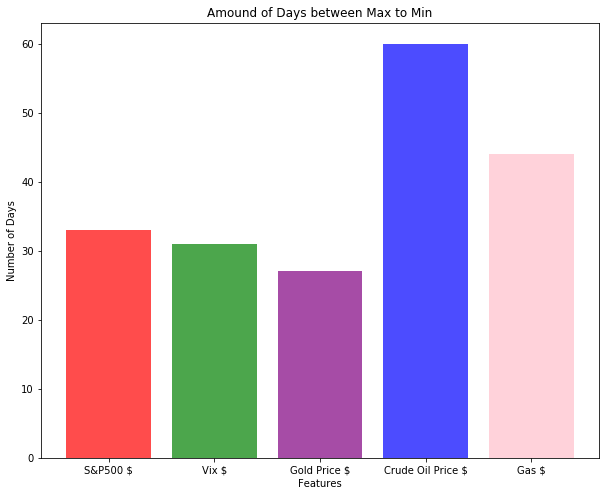

In [31]:
#plot days
x = list(days_dict.keys())
y = list(days_dict.values())
plt.bar(x,y, color = ["red", "green", "purple", "blue", "pink"], alpha=0.7)
plt.xlabel('Features')
plt.ylabel('Number of Days')
plt.title('Amound of Days between Max to Min')
plt.show()

#### Correlation Analysis:

In [32]:
## Getting the correlation between the data
corr_p = df_filtered_by_date_c.corr()
corr_p_copy = corr_p.copy()
corr_p_copy.insert(5, "|| "," || ")

corr_s = df_filtered_by_date_c.corr(method='spearman')
corr_s_copy = corr_s.copy()
corr_s_copy.insert(5, "|| "," || ")

corr_k = df_filtered_by_date_c.corr(method='kendall')
pd.concat([corr_p_copy, corr_s_copy, corr_k], axis=1, keys=["Pearson","Spearman","Kendall"], sort=False)

Pearson                                           \
                   S&P500 $     Vix $ Gold Price $ Crude Oil Price $   
S&P500 $           1.000000 -0.942383     0.030273          0.669498   
Vix $             -0.942383  1.000000    -0.172349         -0.549159   
Gold Price $       0.030273 -0.172349     1.000000         -0.394943   
Crude Oil Price $  0.669498 -0.549159    -0.394943          1.000000   
Gas $              0.636565 -0.549417     0.109491          0.260144   

                                   Spearman                         \
                      Gas $   ||   S&P500 $     Vix $ Gold Price $   
S&P500 $           0.636565   ||   1.000000 -0.953040    -0.012337   
Vix $             -0.549417   ||  -0.953040  1.000000    -0.045316   
Gold Price $       0.109491   ||  -0.012337 -0.045316     1.000000   
Crude Oil Price $  0.260144   ||   0.631736 -0.526337    -0.539862   
Gas $              1.000000   ||   0.608795 -0.540008     0.052460   

                                                      Kendall            \
                  Crude Oil Price $     Gas $   ||   S&P500 $     Vix $   
S&P500 $                   0.631736  0.608795   ||   1.000000 -0.822535   
Vix $                     -0.526337 -0.540008   ||  -0.822535  1.000000   
Gold Price $              -0.539862  0.052460   ||  -0.020487 -0.044570   
Crude Oil Price $          1.000000  0.347144   ||   0.442111 -0.354599   
Gas $                      0.347144  1.000000   ||   0.452821 -0.389844   

                                                            
                  Gold Price $ Crude Oil Price $     Gas $  
S&P500 $             -0.020487          0.442111  0.452821  
Vix $                -0.044570         -0.354599 -0.389844  
Gold Price $          1.000000         -0.337177  0.024622  
Crude Oil Price $    -0.337177          1.000000  0.269369  
Gas $                 0.024622          0.269369  1.000000

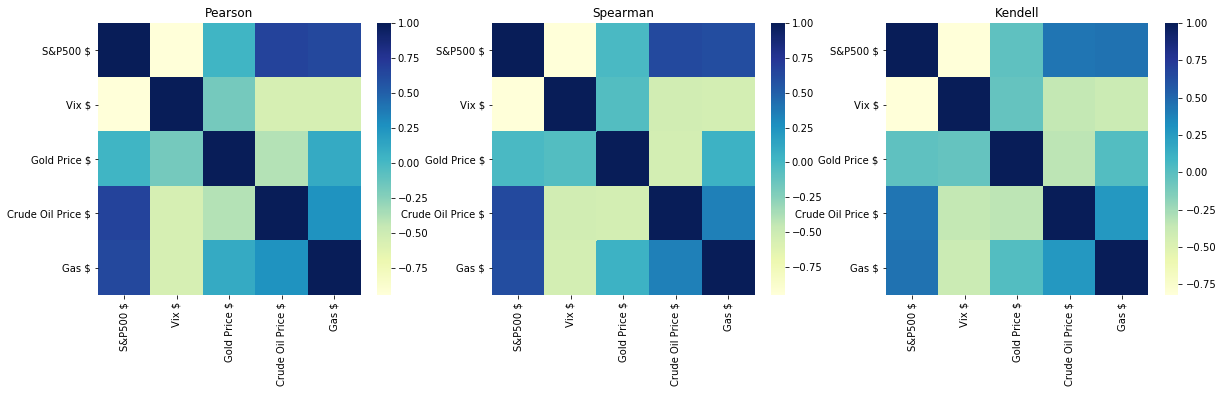

In [33]:
# Plotting the correlations in heatmap form
fig, ax = plt.subplots(1,3,figsize=(20, 5), sharey=False)
sns.heatmap(corr_p, cmap="YlGnBu",ax=ax[0])
ax[0].set_title("Pearson")
sns.heatmap(corr_s, cmap="YlGnBu",ax=ax[1])
ax[1].set_title("Spearman")
sns.heatmap(corr_k, cmap="YlGnBu",ax=ax[2])
ax[2].set_title("Kendell")
plt.show()

#### Pearson: Pairwise correlation 

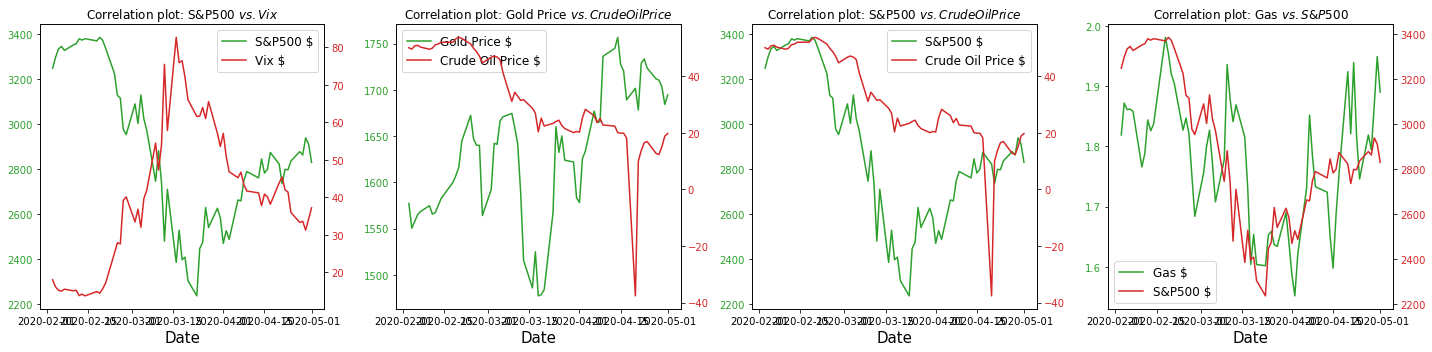

In [34]:
plot_correlation_pairs(corr_p, df_filtered_by_date_c)  

#### Spearman: Pairwise correlation 

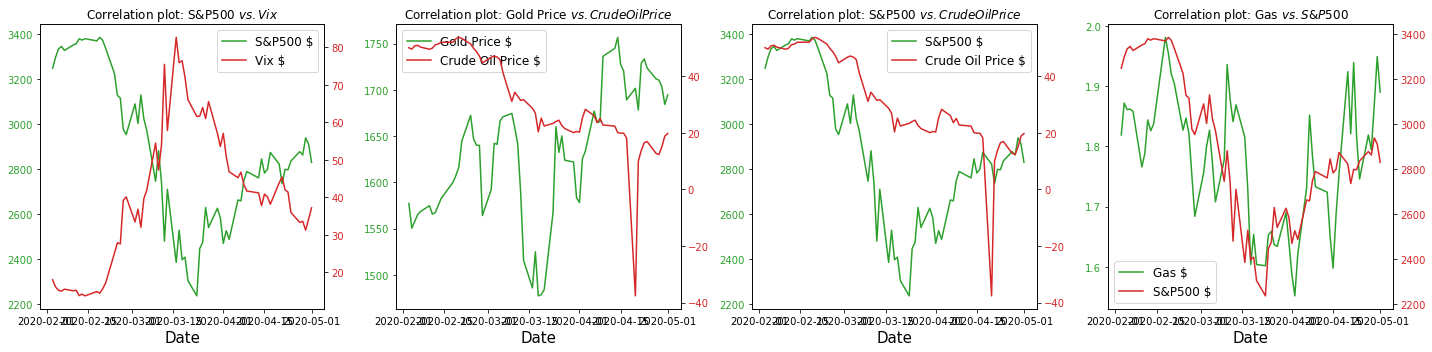

In [35]:
plot_correlation_pairs(corr_s, df_filtered_by_date_c) 

#### Kendall: Pairwise correlation 

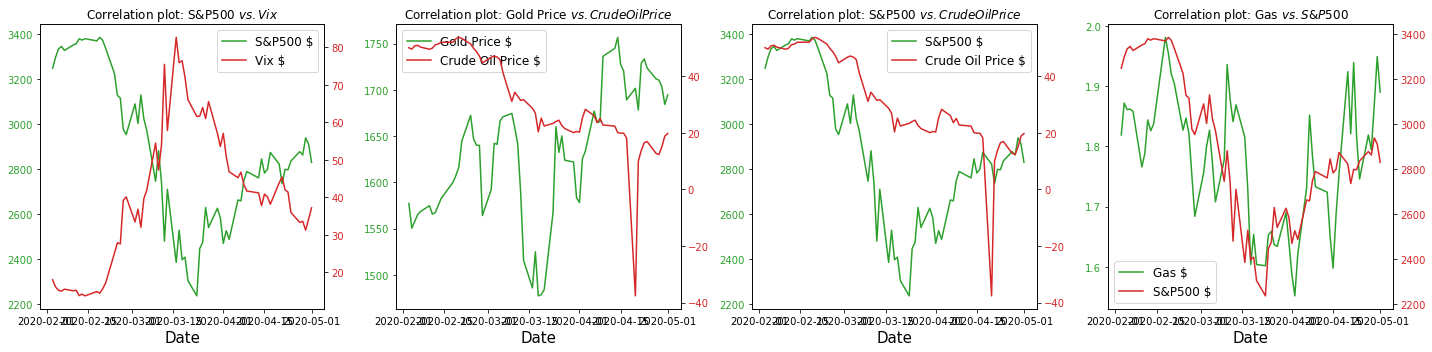

In [36]:
plot_correlation_pairs(corr_k, df_filtered_by_date_c) 

<b>Key Takeaways from the plots:</b>

 - <b> S&P500 and Vix are strongly negativly correlated:</b> 

    The Vix Index is a popular measure of the stock market's expectation of volatility based on S&P 500 index options. When the market goes down, investors would want to purchase insurance, which drives up the prices of put options and increases the VIX. The VIX decreases when there's less demand for put options as the market rises. That's why it tends to move inversely to equities.

 - <b> S&P500 and Crude oil are strongly positively correlated:</b> 

    Expectations of economic growth have an impact on oil prices as increased economic activity generates increased demand for commodities. Under a context of weak economic recovery from OECD countries and tight oil markets because of continued growth in emerging markets, any positive news from the U.S. economy is immediately reflected in higher oil prices. 











## Part 2: Data Processing and Multivariate Linear Regression

### Data Preprocessing

The regression equation as follows:

$$
\hat{y} = h_\theta(\vec{x}) = \theta^T \vec{x} = \theta_0 + \theta_1 x_1 + ... + \theta_n x_n
$$ 

We will start with extracting the target column and assining X,y from the dataset. We use pandas and select both columns as separate variables and transform them into a numpy array.

As the number of features grows, calculating gradients gets computationally expensive. We can speed this up by normalizing the input data to ensure all values are within the same range. This is especially important for datasets with high standard deviations or differences in the ranges of the attributes. Use mean normalization for the features (X) and the true labels (y).

In [71]:
def preprocess(X, y):
    """
    Input:
    - X: Inputs (n features over m instances).
    - y: True labels.

    Returns a two values:
    - X: The mean normalized inputs.
    - y: The mean normalized labels.
    """
    X = (X - X.mean(axis=0))/(X.max(axis=0)-X.min(axis=0))
    y = (y - y.mean())/(y.max()-y.min())
    return X, y

In [72]:
X = df_fin_crisis.drop(columns=['S&P500 $','Date']).values
y = df_fin_crisis['S&P500 $'].values
X, y = preprocess(X, y)

In [73]:
X.shape, y.shape

((1157, 4), (1157,))

### Multivariate Linear Regression Using Gradient Decent

In [74]:
indices = np.random.permutation(X.shape[0])
idx_train, idx_val = indices[:int(0.8*X.shape[0])], indices[int(0.8*X.shape[0]):]
X_train, X_val = X[idx_train], X[idx_val]
y_train, y_val = y[idx_train], y[idx_val]

X_train = X_train[:-1]
y_train = y_train[1:]

X_val = X_val[:-1]
y_val = y_val[1:]

print("X_train shape:",X_train.shape ,"y_train shape:",y_train.shape)
print("X_val shape:",X_val.shape ,"y_val shape:",y_val.shape)

X_train shape: (924, 4) y_train shape: (924,)
X_val shape: (231, 4) y_val shape: (231,)


Make sure that X takes into consideration the bias $\theta_0$ in the linear model. 
$$
\hat{y} = h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1....
$$

In [75]:
# Bias trick
X_train = np.insert(X_train,0,1.0,axis=1)
X_val = np.insert(X_val, 0, 1.0, axis=1)
X_train

array([[ 1.        , -0.02307913,  0.2952144 , -0.05184527, -0.1816775 ],
       [ 1.        , -0.06295513, -0.22836629, -0.03980685, -0.03245499],
       [ 1.        ,  0.4155569 ,  0.15238914, -0.34157669, -0.17713081],
       ...,
       [ 1.        ,  0.03497358,  0.14747188, -0.09380022, -0.25815291],
       [ 1.        , -0.07803192,  0.28169186,  0.05129009, -0.06646426],
       [ 1.        ,  0.02186944,  0.09751657, -0.03567425, -0.25560676]])


Our task is to find the best possible linear hyperplane that explains all the points in our dataset. We start by guessing initial values for the linear regression parameters $\theta$ and updating the values using gradient descent.

The objective of linear regression is to minimize the cost function $J$:

$$
J(\theta) = \frac{1}{2m} \sum_{i=1}^{n}(h_\theta(x^{(i)})-y^{(i)})^2
$$
where the hypothesis (model) $h_\theta(x)$ is given by a linear model:

$$
h_\theta(x) = \theta^T x = \theta_0 + \theta_1 x_1...
$$
$\theta_j$ are parameters of your model. and by changing those values accordingly you will be able to lower the cost function $J(\theta)$. One way to accopmlish this is to use gradient descent:

$$
\theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m (h_\theta(x^{(i)})-y^{(i)})x_j^{(i)}
$$
In linear regresion, we know that with each step of gradient descent, the parameters $\theta_j$ get closer to the optimal values that will achieve the lowest cost $J(\theta)$.

In [76]:
def compute_cost(X, y, theta):
    """
    Input:
    - X: inputs  (n features over m instances).
    - y: true labels (1 value over m instances).
    - theta: the parameters (weights) of the model being learned.

    Returns a single value:
    - J: the cost associated with the current set of parameters (single number).
    """
    J = 0 
    J = ((np.square(np.dot(X, theta)-y)).sum())/(2*X.shape[0])
    return J

In [77]:
def gradient_descent(X, y, theta, alpha, num_iters, epsilon):
    """
    Input:
    - X: Inputs  (n features over m instances).
    - y: True labels (1 value over m instances).
    - theta: The parameters (weights) of the model being learned.
    - alpha: The learning rate of your model.
    - num_iters: The number of updates performed.

    Returns two values:
    - theta: The learned parameters of your model.
    - J_history: the loss value for every iteration.
    """
    J_history = [] # Use a python list to save cost in every iteration
    theta = theta.copy() # avoid changing the original thetas
        
    for i in range(num_iters):
        temp = np.dot((np.dot(X, theta) - y), X)
        theta = theta - (temp*(alpha/X.shape[0]))
        cost = compute_cost(X, y, temp.copy())
        J_history.append(cost)
        if(i > 1 and (J_history[-2] - J_history[-1] < epsilon)):
            break
    return theta, J_history, i

#### Hyper-Tuning: Finding The Best Learning Rate (Alpha) 

In [78]:
def find_best_alpha(X_train, y_train, X_val, y_val, iterations, epsilon):
    """
    Iterate over provided values of alpha and train a model using the 
    *training* dataset. maintain a python dictionary with alpha as the 
    key and the loss on the *validation* set as the value.

    Input:
    - X_train, y_train, X_val, y_val: the training and validation data
    - iterations: maximum number of iterations

    Returns:
    - alpha_dict: A python dictionary - {key (alpha) : value (validation loss)}
    """
    
    alphas = [0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 2, 3]
    alpha_dict = {}
    np.random.seed(42)
    random_theta = np.random.random(size = X_train.shape[1])
    for alpha in alphas:
        np.random.seed(42)
        random_theta = np.random.random(size = X_train.shape[1])
        theta1, _, _ = gradient_descent(X_train, y_train, random_theta, alpha, iterations, epsilon)
        cost = compute_cost(X_val, y_val, theta1)
        alpha_dict[alpha] = cost
    return alpha_dict

In [79]:
alpha_dict = find_best_alpha(X_train, y_train, X_val, y_val, 10000, 1e-180)
print(alpha_dict)
best_alpha = min(alpha_dict, key=alpha_dict.get)
print(f'\n----> The best Alpha found is: {best_alpha}')

{1e-05: 0.14654180939870828, 3e-05: 0.12385563687320499, 0.0001: 0.08430088452464264, 0.0003: 0.05971022886249196, 0.001: 0.04182315661215099, 0.003: 0.03057921453642248, 0.01: 0.02826004433525273, 0.03: 0.028342122243339263, 0.1: 0.028338470051188443, 0.3: 0.028338482941035133, 1: 0.028338540613341113, 2: 0.11917139091176594, 3: 4.051394018082594}

----> The best Alpha found is: 0.01


To better understand the learning rates obtained using different alphas, we decided to plot the best 3 alpha's learning rates

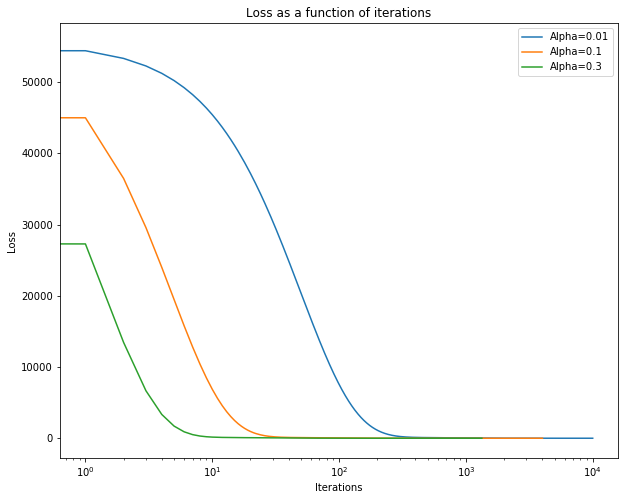

In [80]:
best_alpha_list = []
alpha_dict_copy = alpha_dict.copy()
J_history = []
np.random.seed(42)
random_theta = np.random.random(size = X_train.shape[1])

best_alpha1 = min(alpha_dict_copy, key=alpha_dict_copy.get)
best_alpha_list.append(best_alpha1)
del alpha_dict_copy[best_alpha1]

best_alpha2 = min(alpha_dict_copy, key=alpha_dict_copy.get)
best_alpha_list.append(best_alpha2)
del alpha_dict_copy[best_alpha2]

best_alpha3 = min(alpha_dict_copy, key=alpha_dict_copy.get)
best_alpha_list.append(best_alpha3)
del alpha_dict_copy[best_alpha3]

for alpha in best_alpha_list:
    np.random.seed(42)
    _, J_history_temp, _ = gradient_descent(X_train, y_train, random_theta, alpha, 10000, 1e-180)
    J_history.append(J_history_temp)
    
plt.plot(np.arange(len(J_history[0])), J_history[0], label="Alpha="+str(best_alpha1))
plt.plot(np.arange(len(J_history[1])), J_history[1], label="Alpha="+str(best_alpha2))
plt.plot(np.arange(len(J_history[2])), J_history[2], label="Alpha="+str(best_alpha3))
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations')
plt.legend()
plt.show()

In [81]:
np.random.seed(42)
theta = np.random.random(size=X_train.shape[1])
iterations = 10000
print("Random Theta:", theta)
theta, J_history, iters = gradient_descent(X_train ,y_train, theta, best_alpha, iterations,1e-180)
print("Learned Theta:",theta)

Random Theta: [0.37454012 0.95071431 0.73199394 0.59865848 0.15601864]
Learned Theta: [ 0.00427073  0.04814503 -0.05627998  0.05789183 -0.03731375]


#### Analysis of thetas
1) We see that $ \theta_1 $ has the highest absolute weight out of all the thetas. Based on the statistical analysis we conducted above in the Financial Crisis section, we found that the S&P500 has a strong negative correlation with the VIX index which might explain the strong theta1 weight

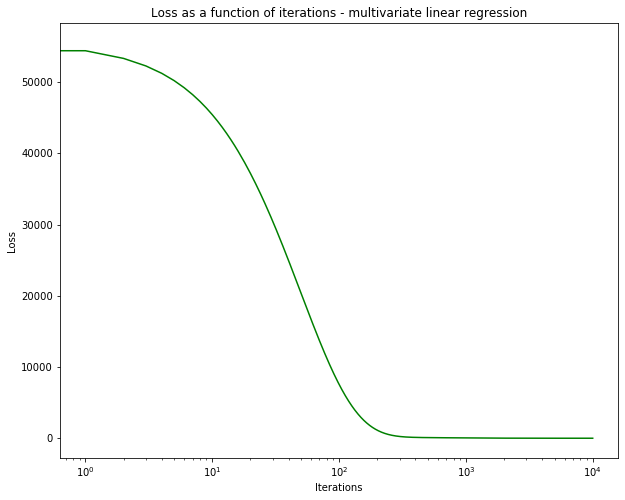

In [82]:
plt.plot(np.arange(iters+1), J_history, color="Green")
plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss as a function of iterations - multivariate linear regression')
plt.show()

We compute the error on the validation data set that our model has no yet seen. Thus, giving us a better picture of the accuracy and generalisation of our model

#### Testing Model on the Financial Validaiton Set

We trained the model on the Financial training set and we now want to see how our model reacts to unseen data

In [83]:
compute_cost(X_val, y_val, theta)

0.02826004433525273

As can be seen above we have very little error in our model. 

#### Testing Model on Covid Data Set

In [84]:
# Dividing into Target and features sets
X_test = df_filtered_by_date_c.drop(columns=['S&P500 $','Date']).values
y_test = df_filtered_by_date_c['S&P500 $'].values
# Shifting  the rows for predicting the next day
X_test = X_test[:-1]
y_test = y_test[1:]
# Prep-process the data & Bias trick
X_test, y_test = preprocess(X_test, y_test)
X_test = np.insert(X_test,0,1.0,axis=1)

In [85]:
# Compute the cost
compute_cost(X_test, y_test, theta)

0.04292091585511584

#### ----------------------->Analysis

## Part 3: Multivariate Linear Regression Using MCMC

In [89]:
# Changing the columns names for ease of use for the MCMC formula
df_filtered_by_date_f.columns = ['Date', 'SP500', 'Vix', 'Gold_Price', 'Crude_Oil_Price','Gas']
formula = 'SP500 ~ ' + ' + '.join(['%s' % variable for variable in df_filtered_by_date_f.columns[2:]])
print("Formula: ",formula)


Formula:  SP500 ~ Vix + Gold_Price + Crude_Oil_Price + Gas


In [90]:
# This time we want to keep X_train as dataframe as oppose to the a numpy array
X_train = df_filtered_by_date_f.drop(columns=['Date'])
temp = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(temp)
X_train = pd.DataFrame(x_scaled, columns=['SP500', 'Vix', 'Gold_Price', 'Crude_Oil_Price','Gas'])
X_train

,SP500,Vix,Gold_Price,Crude_Oil_Price,Gas
0,1.000000,0.106413,0.509889,0.590693,0.311290
1,1.000000,0.095880,0.541401,0.586740,0.289855
2,0.948857,0.118340,0.530338,0.575330,0.310194
3,0.955407,0.116016,0.518605,0.549996,0.314822
4,0.917996,0.141419,0.580288,0.561136,0.325539
...,...,...,...,...,...
248,0.198929,0.392348,0.551123,0.046357,0.068810
249,0.251914,0.352850,0.510560,0.134220,0.082450
250,0.221974,0.419610,0.456587,0.078699,0.094751
251,0.226408,0.406753,0.499497,0.070344,0.083912


In [93]:
# Context for the model
with pm.Model() as normal_model:
    # The prior for the model parameters will be a normal distribution
    family = pm.glm.families.Normal()
    # Creating the model requires a formula and data (and optionally a family)
    pm.GLM.from_formula(formula, data = X_train, family = family)
    # Perform Markov Chain Monte Carlo sampling
    normal_trace = pm.sample(draws=1000, chains = 1, tune = 1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sd, Gas, Crude_Oil_Price, Gold_Price, Vix, Intercept]


Sampling 1 chain for 1_000 tune and 1_000 draw iterations (1_000 + 1_000 draws total) took 1415 seconds.
The acceptance probability does not match the target. It is 0.8810618114766657, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


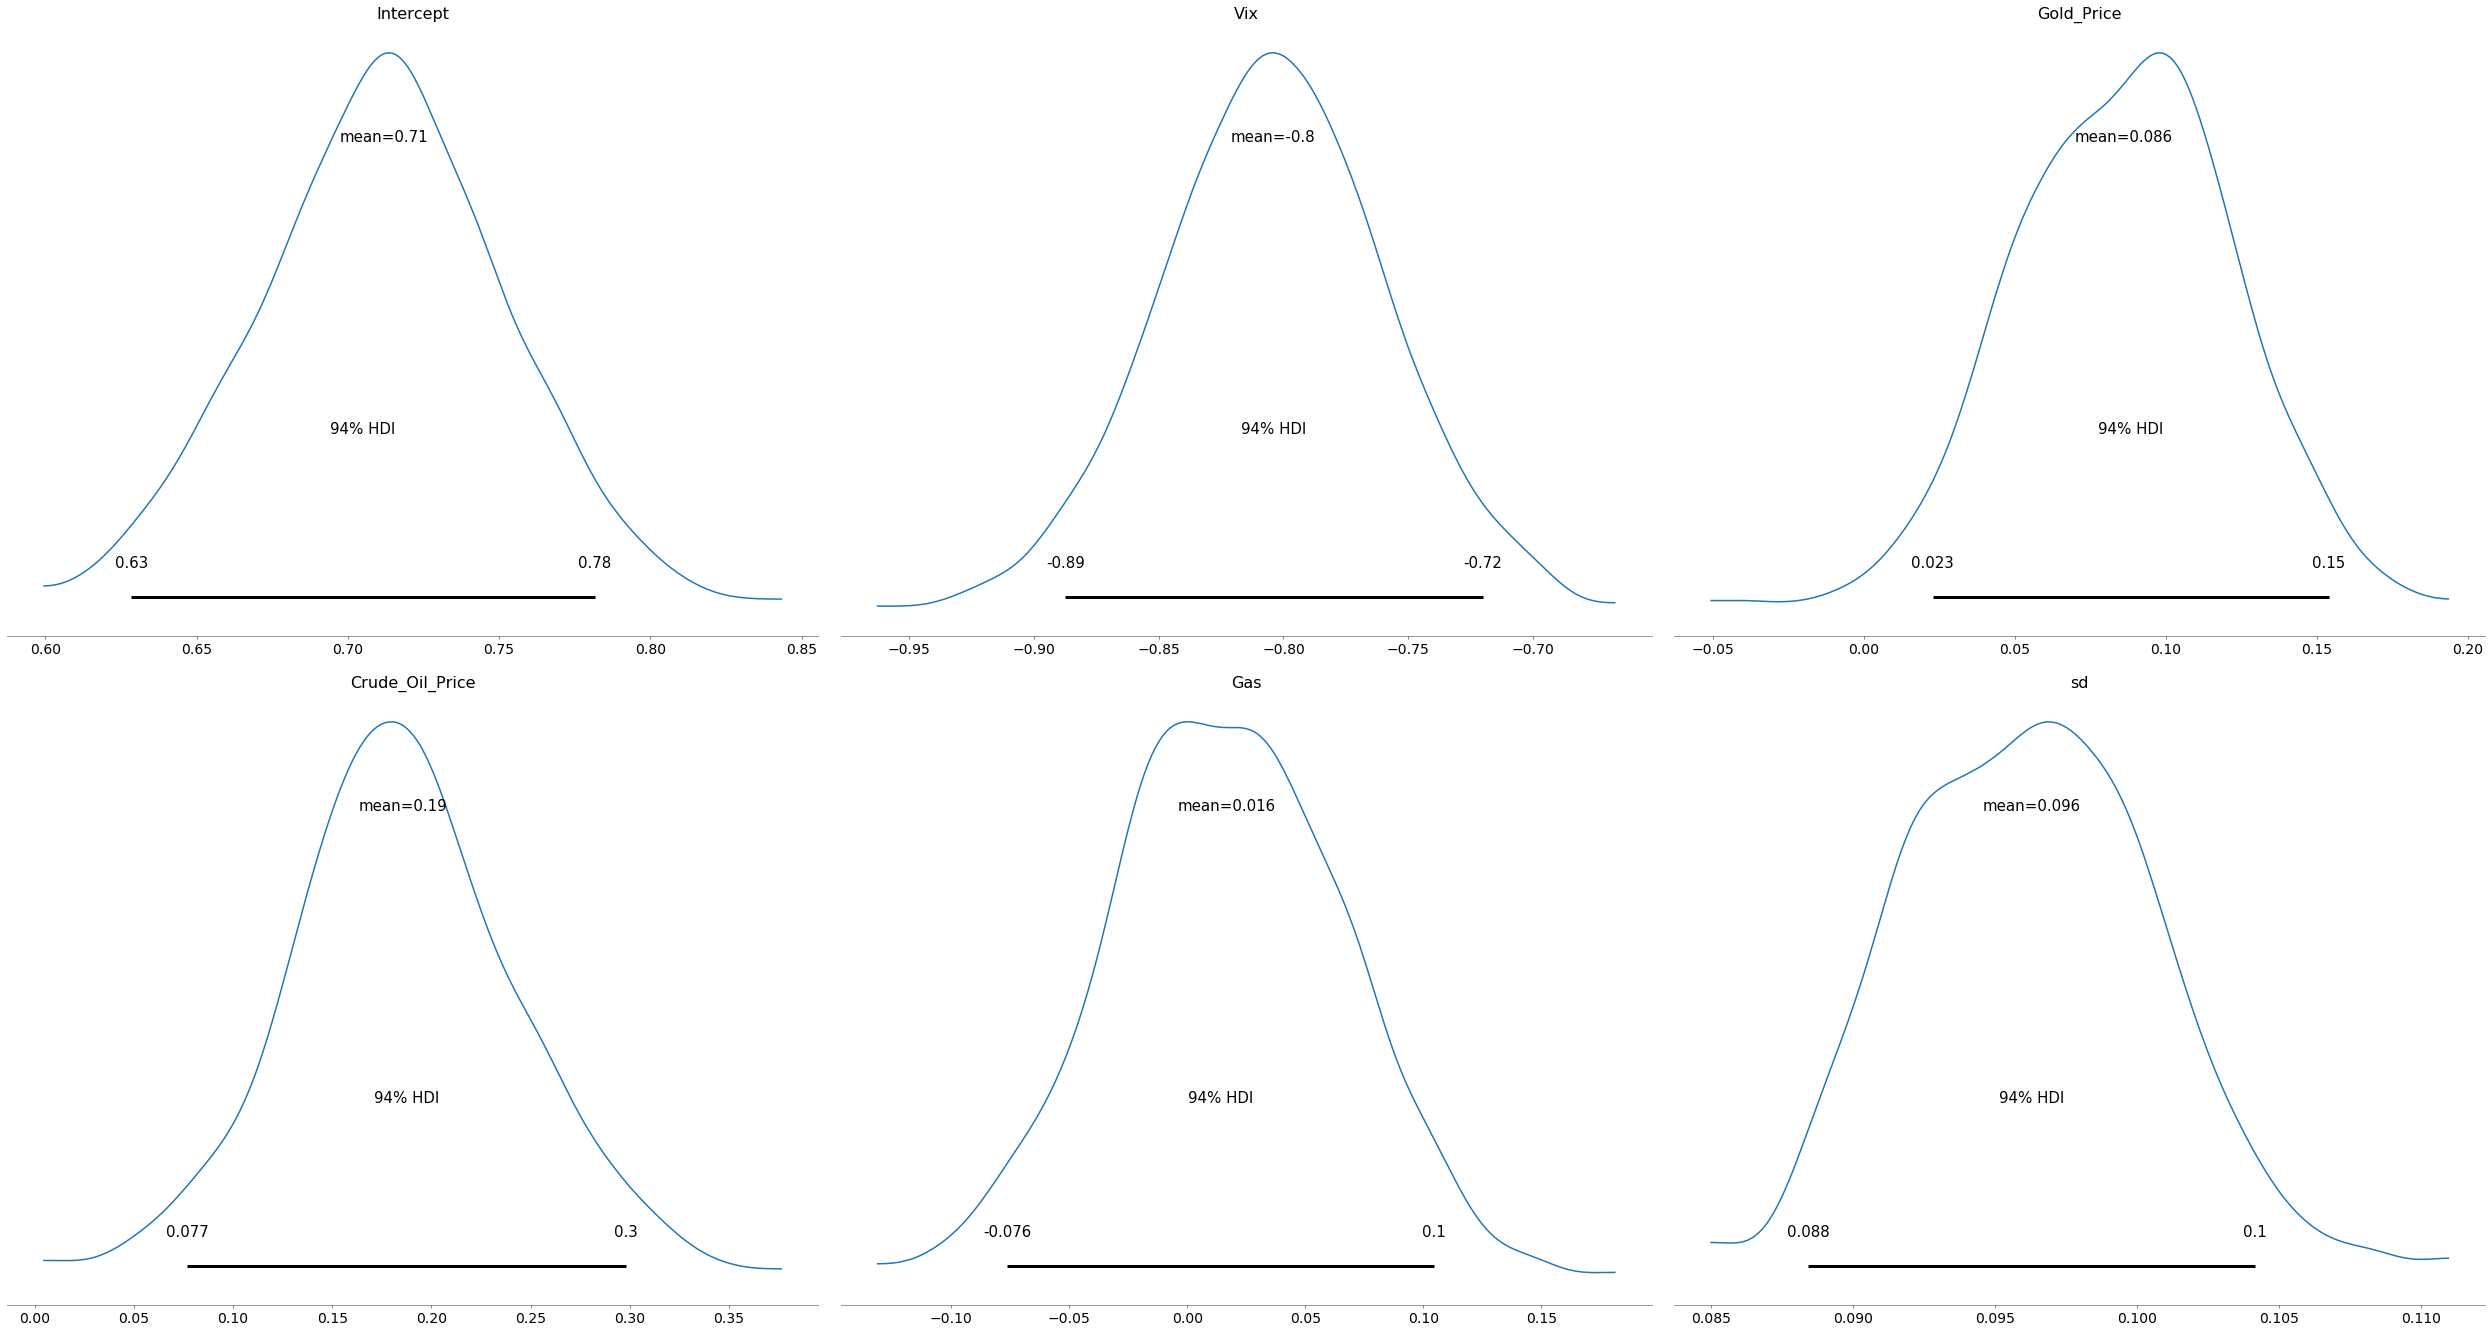

In [94]:
import warnings
warnings.filterwarnings('ignore')
pm.plot_posterior(normal_trace);

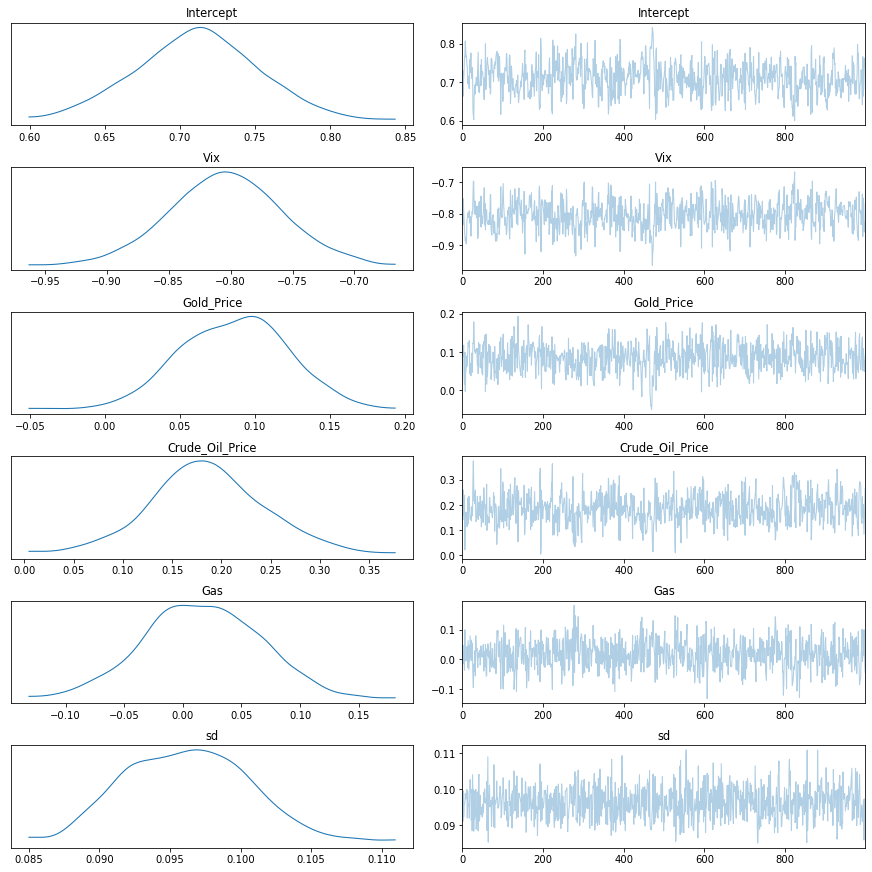

In [95]:
pm.traceplot(normal_trace);

In [97]:
df_summary = pm.summary(normal_trace)
df_summary

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,0.712,0.040,0.628,0.782,0.002,0.002,278.0,254.0,281.0,272.0,NaN
Vix,-0.804,0.044,-0.887,-0.720,0.002,0.002,323.0,313.0,333.0,543.0,NaN
Gold_Price,0.086,0.036,0.023,0.154,0.002,0.001,435.0,435.0,457.0,398.0,NaN
Crude_Oil_Price,0.186,0.058,0.077,0.298,0.003,0.002,358.0,358.0,376.0,382.0,NaN
Gas,0.016,0.049,-0.076,0.105,0.002,0.002,526.0,351.0,527.0,627.0,NaN
sd,0.096,0.004,0.088,0.104,0.000,0.000,1005.0,1004.0,997.0,811.0,NaN


In [98]:
[θ0, θ1, θ2, θ3, θ4] = df_summary['mean'][:-1]
theta = [θ0, θ1, θ2, θ3, θ4]

In [100]:
# Dividing into Target and features sets
X_test = df_filtered_by_date_c.drop(columns=['S&P500 $','Date']).values
y_test = df_filtered_by_date_c['S&P500 $'].values
# Shifting  the rows for predicting the next day
X_test = X_test[:-1]
y_test = y_test[1:]
# Prep-process the data & Bias trick
X_test, y_test = preprocess(X_test, y_test)
X_test = np.insert(X_test,0,1.0,axis=1)

In [101]:
compute_cost(X_test, y_test, theta)

0.2589692592739919

#### ----------------------->Analysis

# References

- https://www.gold-and-silver.net/articles/5-reasons-why-gold-is-valuable/
-https://marketrealist.com/2015/12/correlation-gold-oil/#:~:text=As%20crude%20oil%20prices%20rise,only%20increases%20when%20inflation%20rises.&text=Gold%20and%20crude%20oil%20are%20further%20related%20in%20that%20a,to%20its%20excessive%20industrial%20use.